In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.test_utils import download
import os.path as osp
import mxnet.image as image
import os
import numpy as np
from mxnet.contrib.ndarray import MultiBoxTarget


def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)

def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1,padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def body():
    out = nn.HybridSequential()
    for filter in [16,32,64]:
        out.add(down_sample(filter))
    return out
        
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

#Download the Pikachu dataset
def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        print('Found hash mismatch in file {}, possibly due to incomplete download.'.format(file_path))
    return matched

def download_pikachu():
    url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/{}'
    hashes = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
              'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
              'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in hashes.items():
        fname = 'pikachu_' + k
        target = osp.join('data', fname)
        url = url_format.format(k)
        if not osp.exists(target) or not verified(target, v):
            print('Downloading', target, url)
            download(url, fname=fname, dirname='data', overwrite=True)
            
def get_iterators(data_shape, batch_size, data_path = './dataset/pikachu'):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=os.path.join(data_path,'pikachu_train.rec'),
        path_imgidx=os.path.join(data_path,'pikachu_train.idx'),
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=os.path.join(data_path, 'pikachu_val.rec'),
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [84]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), downsamples, class_preds, box_preds
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds
    
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)
    
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  
ctx = mx.cpu()


net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})


In [85]:
# n = 40
# # shape: batch x channel x height x weight
# x = nd.random_uniform(shape=(1, 3, n, n))

# y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# # the first anchor box generated for pixel at (20,20)
# # its format is (x_min, y_min, x_max, y_max)
# boxes = y.reshape((n, n, -1, 4))
# print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

# cls_pred = class_predictor(5, 10)
# cls_pred.initialize()
# x = nd.zeros((2, 3, 20, 20))
# print('Class prediction', cls_pred(x).shape)

# box_pred = box_predictor(10)
# box_pred.initialize()
# x = nd.zeros((2, 3, 20, 20))
# print('Box prediction', box_pred(x).shape)


# blk = down_sample(10)
# blk.initialize()
# x = nd.zeros((2, 3, 20, 20))
# print('Before', x.shape, 'after', blk(x).shape)

# colors = ['blue', 'green', 'red', 'black', 'magenta']
# plt.imshow(nd.ones((n, n, 3)).asnumpy())
# anchors = boxes[20, 20, :, :]
# for i in range(anchors.shape[0]):
#     plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
# plt.show()

# bnet = body()
# bnet.initialize()
# x = nd.zeros((2,3,256,256))

# print('Body network', [y.shape for y in bnet(x)])


In [86]:
data_shape = 256
batch_size = 32

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


[0.         0.3539974  0.26543182 0.5266102  0.42114696]


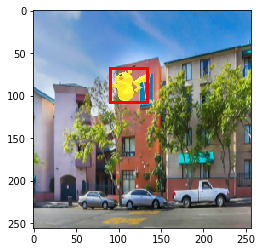

In [87]:

img = batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)
# draw bounding boxes on image
for label in batch.label[0][0].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    plt.gca().add_patch(rect)
plt.imshow(img)
plt.show()